# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [2]:
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc2)


In [4]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
#import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0-rc2


# Task 2: Importing and Plotting the Data

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#x_train = tf.keras.datasets.mnist.load_subsets([0], x_train, y_train)
#x_test = tf.keras.datasets.mnist.load_subsets([0], x_test, y_train)

train_filter = np.where((y_train == 0 ))
test_filter = np.where((y_test == 0))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x = np.concatenate([x_train, x_test], axis=0)

<module 'tfutils' from '/usr/local/lib/python3.6/dist-packages/tfutils/__init__.py'>

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [0]:
discriminator = Sequential([
  Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
  LeakyReLU(),
  BatchNormalization(),

  Conv2D(128, 5, strides=2),
  LeakyReLU(),
  BatchNormalization(),

  Conv2D(256, 5, strides=2),
  LeakyReLU(),
  BatchNormalization(),

  Flatten(),
  Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)



discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 1, 256)       

# Task 4: Generator

In [7]:
generator = Sequential([
  Dense(256, activation='relu', input_shape=(1, )),
  Reshape((1, 1, 256)),

  Conv2DTranspose(256, 5, activation='relu'),
  BatchNormalization(),

  Conv2DTranspose(128, 5, activation='relu'),
  BatchNormalization(),

  Conv2DTranspose(64, 5, strides=2, activation='relu'),
  BatchNormalization(),

  Conv2DTranspose(32, 5, activation='relu'),
  BatchNormalization(),

  Conv2DTranspose(1, 4)
])

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)        2

In [8]:
noise = np.random.randn(1, 1)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary')
plt.savefig('genimg_initial.png')

<IPython.core.display.Javascript object>

# Task 5: Generative Adversarial Network (GAN)

In [0]:
input_layer = tf.keras.layers.Input(shape=(1, ))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_11 (Sequential)   (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [0]:
epochs = 25
batch_size = 128
steps_per_epoch = int(2* x.shape[0]/batch_size)

print('steps_per_epoch', steps_per_epoch)

steps_per_epoch 107


In [0]:
#dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))
images = []

for e in range(0, epochs):
  #dp.start_of_epoch(e)

  for step in range(0, steps_per_epoch):
    true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step+1)]
    true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))

    noise = np.random.randn(int(batch_size/2), 1)
    #print(noise)
    gen_examples = generator.predict(noise)

    x_batch = np.concatenate([gen_examples, true_examples], axis=0)
    y_batch = np.array([0] * int(batch_size/2) + [1]*int(batch_size/2))

    indices = np.random.choice(range(batch_size), batch_size, replace=False)

    x_batch = x_batch[indices]
    y_batch = y_batch[indices]

    discriminator.trainable = True
    discriminator.train_on_batch(x_batch, y_batch)
    discriminator.trainable = False

    loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
    _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)

  noise = np.random.randn(1, 1)
  gen_image = generator.predict(noise)[0]
  gen_image = np.reshape(gen_image, (28, 28))
  plt.imshow(gen_image)
  images+=[gen_image]
  plt.show()

  #dp.end_of_epoch(gen_image, 'binary', 'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))

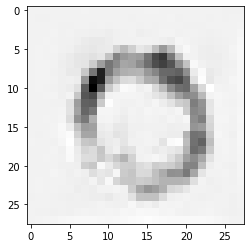

In [0]:
#configure_plotly_browser_state()

plt.imshow(images[2], cmap='binary')
plt.show()



In [0]:
import datetime
from datetime import date
import pandas as pd
import numpy as np
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()
init_notebook_mode(connected=False)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
np.random.randn(int(batch_size/2), 1).shape

(64, 1)

In [0]:
plt.imshow(gen_image)
plt.savefig('1.png')

In [0]:
import numpy as np
x = np.zeros((10, 10))
y = np.ones((5, 11))

np.concatenate([x,y], axis=0)

ValueError: ignored